In [4]:
# import autograd functionality
import autograd.numpy as np
#from autograd.util import flatten_func
from autograd.util import flatten_func
from autograd import grad as compute_grad   
import math
import sys
# import custom utilities
import custom_utilities as util

# import various other libraries
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
csv = open('final_project_data/final_project_point_cloud.fuse', 'r')
data=[]
num=0
for line in csv:
    ls=line.split(" ")
    data.append([float(ls[0]),float(ls[1]),float(ls[2]),float(ls[3][:-1])])
    num += 1
csv.close()
data=np.array(data)
#print(data)
print(num)
lat, long, height, i = data.T

430736


In [6]:
print(data[0])
lat0 = data[0][0]
lon0 = data[0][1]

[ 45.9038834   11.02841352 232.4648      10.        ]


In [7]:
def latlontoxy(lat1, lon1, lat0,lon0):
    m_per_deg_lat = 111132.954 - 559.822 * math.cos( 2.0 * lat0 ) + 1.175 * math.cos( 4.0 * lat0);
    m_per_deg_lon = (3.14159265359/180 ) * 6367449 * math.cos ( lat0 );
    x = (lat1-lat0) * m_per_deg_lat
    y = (lon1-lon0) * m_per_deg_lon
    return x,y

In [8]:
model = []
for d in data:
    h = np.zeros(4)
    h[0],h[1]=latlontoxy(d[0],d[1],lat0,lon0)

    h[2]=d[2]
    h[3]=d[3]
    model.append(h)
model=np.array(model)

In [9]:
#randomly select all points for the linear regression
#sample = np.array(random.sample(list(model), 4300))
sample=model
#print(np.ones(len(sample))[:, np.newaxis])
sample_pos=np.concatenate((np.ones(len(sample))[:, np.newaxis],sample[:,:-1]),axis=1)
#print(sample_pos)

In [10]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

In [11]:
# normalize a dataset
sample_pos_means = np.mean(sample_pos,axis = 0)
sample_pos_stds = np.std(sample_pos,axis = 0)

# a normalization function 
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data
# normalize data using the function above
#x_orig = copy.deepcopy(x)     # make a copy of the original input
#print(sample_pos_means,sample_pos_stds)
sample_pos_norm = normalize(sample_pos[:,1:],sample_pos_means[1:],sample_pos_stds[1:])
sample_pos_norm = np.concatenate((np.ones(len(sample_pos))[:, np.newaxis],sample_pos_norm),axis=1)
#print(sample_pos_norm)
z_norm = sample_pos_norm[:,-1][:,np.newaxis]
#z_norm.shape(len(z_norm,1))
data_norm = sample_pos_norm[:,:-1]
print(data_norm)
print(z_norm)

[[ 1.         -0.33009207 -0.4808317 ]
 [ 1.         -1.26529022  0.47769236]
 [ 1.         -1.26921864  0.4704406 ]
 ...
 [ 1.          1.61620693 -0.55295197]
 [ 1.          1.69650573 -1.02317413]
 [ 1.          1.58379745 -0.41988709]]
[[ 9.12060978]
 [11.64685528]
 [11.61574636]
 ...
 [ 0.07761312]
 [ 0.08202126]
 [ 0.67649124]]


In [12]:
# def sigmoid(z):
#     sig = 1 / (1 + np.exp(-z))
#     return sig
# #x is N*4 shape with bias, w is 4*1 shape with bias,thre is the threshold
# def threshold(w):
#     dis = np.power(np.dot(sample_pos_norm,w),2)-0.1
#     num = sigmoid(dis)
#     NUM = np.sum(num)
#     return NUM
# #return array
# def point_num(sample_pos_norm,weight):
#     dis = np.power(np.dot(sample_pos_norm,weight),2)-0.46
#     num = sigmoid(dis)
#     return num

In [13]:
w = np.random.randn(3,1)*0.01
print(w)
# least squares MSE rergession
least_squares = lambda w: np.sum((np.dot(data_norm,w) - z_norm)**2)
alpha = 10**(-3)
max_its = 800

[[ 0.01106627]
 [-0.00232245]
 [-0.00696783]]


In [14]:
# run gradient descent
weight_history = gradient_descent(least_squares,w,alpha,max_its,beta = 0,version = 'normalized')

# plot cost function history
cost_history = [least_squares(v) for v in weight_history]
histories = [cost_history]

<IPython.core.display.Javascript object>


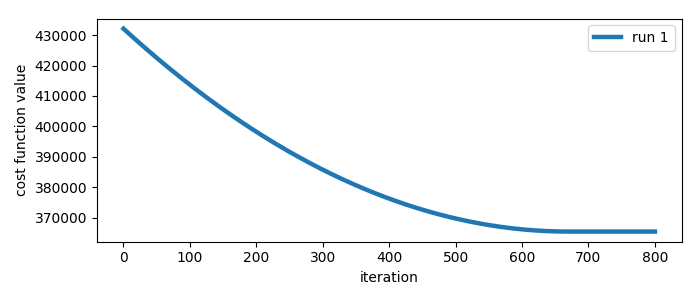

In [15]:
# plot everything
demo = util.Visualizer()
demo.compare_regression_histories(histories)

In [16]:
print(weight_history[-1])
final_w_norm = weight_history[-1]
#threshold numbers
thresholds = (z_norm-np.dot(data_norm,final_w_norm))**2
print(thresholds.shape)
print(thresholds)

[[-1.37610927e-12]
 [ 4.64367658e-01]
 [ 4.73549764e-01]]
(430736, 1)
[[9.02802429e+01]
 [1.44196964e+02]
 [1.43576793e+02]
 ...
 [1.68962788e-01]
 [4.89547761e-02]
 [1.95620392e-02]]


In [17]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.hist(thresholds, 20)
# plt.show()

In [18]:
data_filtered_z = []
for d in range(len(model)):
    if thresholds[d] < 0.05:
        data_filtered_z.append(model[d])
data_filtered_z = np.array(data_filtered_z)

[[-1.25115387e+01 -3.10711376e+00  2.24651900e+02  2.80000000e+01]
 [-2.00106527e+01 -1.25949621e+00  2.24724700e+02  3.60000000e+01]
 [-2.21570816e+01 -4.43000487e-02  2.24431000e+02  2.80000000e+01]
 ...
 [ 4.85077320e+01 -4.47430492e+00  2.25281600e+02  5.00000000e+00]
 [ 4.83437377e+01 -4.16993304e+00  2.25288300e+02  5.00000000e+00]
 [ 4.56551235e+01  4.68587585e-01  2.25760300e+02  8.00000000e+00]]


<IPython.core.display.Javascript object>


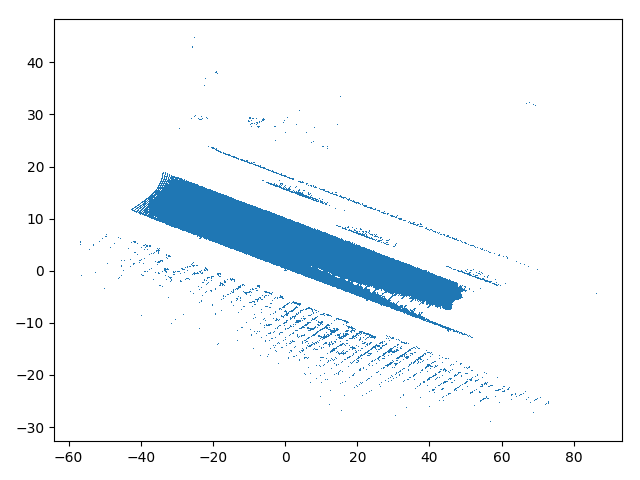

In [19]:
print(data_filtered_z)

xs= data_filtered_z[:,0]
ys= data_filtered_z[:,1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xs, ys, ',')
plt.show()

76.0 89.0


<IPython.core.display.Javascript object>


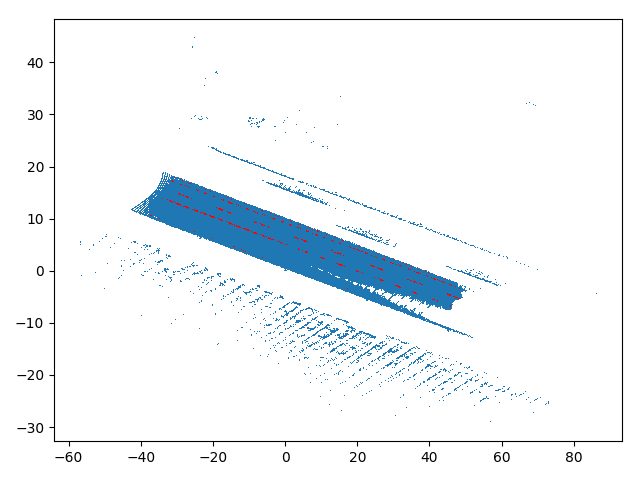

In [20]:
lane_data = []
I = data_filtered_z[:,-1]
si = sorted(I)[int(0.996*len(I)):int(0.9995*len(I))]
mini = min(si)
maxi = max(si)
print("{} {}".format(mini, maxi))
for d in data_filtered_z:
    if d[3] >= mini and d[3] <= maxi:
        lane_data.append(d[:-1])

lane_data = np.array(lane_data)
lx, ly, lz = lane_data.T

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xs, ys, ',')
ax.plot(lx, ly, ',', color='red')
plt.show()

In [21]:
# print(weight_history[-1])
# final_w_norm = weight_history[-1]
# #get the normalized final weights
# w0_n=final_w_norm[0][0]
# w1_n=final_w_norm[1][0]
# w2_n=final_w_norm[2][0]
# w3_n=final_w_norm[3][0]
# #mean and stds
# xm = sample_pos_means[1]
# ym = sample_pos_means[2]
# zm = sample_pos_means[3]
# xd = sample_pos_stds[1]
# yd = sample_pos_stds[2]
# zd = sample_pos_stds[3]

# w1 = w1_n*yd*zd
# w2 = w2_n*xd*zd
# w3 = w3_n*yd*xd
# w0 = w0_n*xd*yd*zd - w1_n*yd*zd*xm - w2_n*xd*zd*ym - w3_n*xd*yd*zm
# #final weight
# final_weight = np.array([[w0],[w1],[w2],[w3]])
# print(sample_pos_means,sample_pos_stds)
# print(final_weight)

In [22]:
# num = point_num(sample_pos_norm,final_w_norm)
